In [1]:
%pylab inline
import pandas as pd
import emcee
import time
import os
import sys
import corner
from astropy.constants import au,h,pc,c
import glob
import pickle
import pdb as pdb
from slabspec import *
from flux_calculator import *
from slab_fitter import * 
from scipy.optimize import minimize
import random
from mcmc import rot_mcmc, loglikelihood
from helpers import *


Populating the interactive namespace from numpy and matplotlib


### Run on minimum necessary arguments

In [2]:
data=pickle.load(open('fztau_fluxes.p','rb'))

del(data['wn'],data['a'],data['elower'],data['gup'],data['Qp_HITRAN'], data['glow'],data['nu'],data['eup_k'])
del(data['wave'],data['Qup'],data['Qlow'],data['linewidth'],data['linewidth_err'],data['v_dop_fit'],data['v_dop_fit_err'],data['continuum'],data['continuum_err'])


data

molec_id,local_iso_id,Vp_HITRAN,Vpp_HITRAN,Qpp_HITRAN,Vup,Vlow,lineflux,lineflux_err
,,,,,,,W / m2,W / m2
int32,int32,bytes15,bytes15,bytes15,float64,float64,float64,float64
5,1,1,0,P 9,1.0,0.0,1.316994343354751e-16,7.825901269238242e-17
5,1,1,0,P 8,1.0,0.0,1.0323862164516226e-16,3.4120979639822254e-17
5,1,1,0,P 7,1.0,0.0,9.367185275616444e-17,2.4365401504170184e-17
5,1,1,0,P 6,1.0,0.0,9.465862409709585e-17,1.7634261314132918e-17
5,1,1,0,P 5,1.0,0.0,6.893828434186451e-17,2.3441294346321396e-17
5,1,1,0,P 3,1.0,0.0,8.537210549683167e-17,1.2019031142384293e-17
5,1,1,0,P 2,1.0,0.0,6.987527727948783e-17,2.101648574489899e-17
5,1,1,0,R 0,1.0,0.0,2.743133787053756e-17,2.151658840947691e-17


array([[ 21.77801406, 903.51346796, -14.98341022],
       [ 21.77801406, 903.51346796, -14.98341022],
       [ 21.75443216, 874.6312653 , -14.89445289],
       ...,
       [ 21.01541625, 730.62103543, -14.26105472],
       [ 21.02432918, 735.25180676, -14.27434117],
       [ 21.02432918, 735.25180676, -14.27434117]])

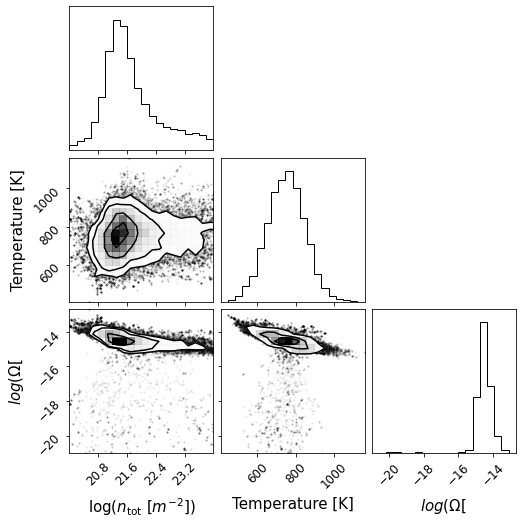

In [3]:
rot_mcmc(data)

## Running on synthetic data set

In [4]:
def sangle_to_area(omega, distance):
    return omega*(distance*3.1e16)**2

size = 1

distance=140

for k in arange(size):
    
    result = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
    
    # Set random variables
    logn = np.random.random()*4+20
    temp = np.random.normal(750, 100)
    logomega = np.random.random()*9-21
    
    result[0] = round(logn,4)
    result[1] = round(temp,4)
    result[2] = round(logomega,4)
    result[9] = round(distance,4)
    
    
    params = np.array([logn, temp, logomega, distance])
    
    # Make spectrum
    spec = make_spec('CO', 10**params[0], params[1], sangle_to_area(10**params[2], params[3]), 
                     wmin=4.6, wmax=5.02, isotopologue_number = 1, d_pc=distance)
    
    #synthdata = spec['lineparams']
    
    
    # Adding error to lineflux measures
    
    mean_lineflux = mean(synthdata['lineflux'])
    
    errorpercent = 0.1

    sigma = np.random.normal(errorpercent, errorpercent*0.3, len(synthdata))*mean_lineflux

    synthdata['lineflux'] += sigma
    synthdata['lineflux_err'] = np.zeros(len(synthdata['lineflux']))+errorpercent*mean_lineflux
  
        
    #postsamples = rot_mcmc(synthdata[mybool], plot=False)
    
    fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot}$ $[m^{-2}])$",r"Temperature [K]", "$log(\Omega [])$"], truths=[params[0], params[1], params[2]])


#     fig.text(.7,0.9,'logn = '+str(round(params[0],1)),fontsize=18)
#     fig.text(.7,0.8,'temp = '+str(round(params[1],1)),fontsize=18)
#     fig.text(.7,0.7,'logomega = '+str(round(params[2],1)),fontsize=18)
#     fig.text(.7,0.6,'dist = '+str(round(params[3],1))+'pc',fontsize=18)
#     fig.savefig("./SynthSets/Synthetictest"+str(k+3)+".eps")
    
    
    

NameError: name 'synthdata' is not defined

## Maximum Likelihood best-fit

In [ ]:
lognguess = 22
tguess = 750
logomegaguess = -16.5



func = lambda *args: -loglikelihood(*args)

thetaguess = np.array([lognguess, tguess, logomegaguess])

MLE = minimize(func, thetaguess, args=(myrun.lineflux, myrun.lineflux_err, myrun))

fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot}$ $[m^{-2}])$",r"Temperature [K]", "$log(\Omega)$"], truths=MLE['x'],label_kwargs={"fontsize": 15})
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
fig.savefig('MLE.eps')

## Corner plot on real data

In [ ]:
fig = corner.corner(postsamples, labels=[ r"$\log(n_\mathrm{tot}$ $[m^{-2}])$",r"Temperature [K]", "$log(\Omega)$"], truths=MLE['x'],label_kwargs={"fontsize": 15})
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
fig.savefig('MLE.eps')



## Best fit parameters with error bars

In [ ]:
from IPython.display import display, Math
labels=[ r"log(Ntot)",r"Temperature", "Omega"]
for i in range(3):
    mcmc = np.percentile(postsamples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

## Plot of best fit

In [ ]:
bestfit=[np.percentile(postsamples[:,i],50) for i in range(3)]
modelflux=compute_fluxes(myrun, bestfit[0],bestfit[1],10**(bestfit[2]))
rotdiag=make_rotation_diagram(data,modelfluxes=modelflux)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.set_xlabel('Upper Level Energy [Kelvin]')
ax1.legend()

## Plot of some random samples

In [ ]:

fig=plt.figure()
ax1=fig.add_subplot(111)
inds = np.random.randint(len(postsamples), size=100)
for ind in inds:
    sampley = postsamples[ind]
    modelflux=compute_fluxes(myrun, sampley[0],sampley[1],10.**sampley[2])
    rotdiag=make_rotation_diagram(data,modelfluxes=modelflux)
    ax1.plot(rotdiag['x'],rotdiag['modely'],alpha=0.2)
ax1.set_xlabel('Upper Level Energy [Kelvin]')

bestfit=[np.percentile(postsamples[:,i],50) for i in range(3)]
modelflux=compute_fluxes(myrun, bestfit[0],bestfit[1],10**(bestfit[2]))
rotdiag=make_rotation_diagram(data,modelfluxes=modelflux)
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')